In [1]:
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [2]:
SIFT_method = False
scaler = StandardScaler() 



Questa funzione prende in ingresso l'immagine originale, l'immagine ritagliata e il nome del salvataggio. Restituisce un immagine che rappresenta la zona di lavoro

In [3]:
def cutWorkSpace(img,border): 
    # dimensioni immagini
    img_h = 2048
    img_l = 2048
    # offset per posizionamento su area d'indagine
    offset_x = 600
    offset_y = 500
    
    #taglio per garantire la ricerca sull'area di interesse, evitando rumori dati dallo sfondo
    crop_img = img[offset_y:img_h-offset_y, offset_x:img_l-offset_x]
    
    # Convert the img to grayscale
    gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #cv2.imwrite('provaT.jpg', thresh_im)
    lowThresh = 0.5*high_thresh
    
    
    # Apply edge detection method on the image
    #edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    cv2.imwrite('canny.jpg', edges)
    # This returns an array of r and theta values
    lines = cv2.HoughLines(edges,1,np.pi/180, 100)
    #cv2.imwrite('Risultati/resFS'+name+'c.jpg', edges)
    # The below for loop runs till r and theta values 
    # are in the range of the 2d array
    i = 0
    x_first = 0
    x_second = 0
    count = 0
    delta = 30

    while count < 2:
        for r,theta in lines[i]:
            # Stores the value of cos(theta) in a
            a = np.cos(theta)

            # Stores the value of sin(theta) in b
            b = np.sin(theta)

            # x0 stores the value rcos(theta)
            x0 = a*r

            # y0 stores the value rsin(theta)
            y0 = b*r

            #ti define line lenght
            const = 3000
            # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
            x1 = int(x0 + const*(-b))

            # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
            y1 = int(y0 + const*(a))

            # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
            x2 = int(x0 - const*(-b))

            # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
            y2 = int(y0 - const*(a))

            if count == 0 :
                
                x_first = x0
                #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                count += 1
            else:
                if abs(x_first-x0) > delta :
                    x_second = x0
                    #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                    count += 1
            i += 1
    # All the changes made in the input image are finally
    # written on a new image houghlines.jpg
    #cv2.imwrite('Risultati/res'+name+'.jpg', img)
    
    if x_first < x_second:
        temp = img[0:img_h-1, int(offset_x+x_first-border):int(offset_x+x_second+border)]
        blurred = cv2.GaussianBlur(temp, (3, 3), 0)
        return  temp
    else:
        temp = img[0:img_h-1, int(offset_x+x_second-border):int(offset_x+x_first+border)]
        blurred = cv2.GaussianBlur(temp, (3, 3), 0)
        return  temp

In [4]:
def divideImage(img,pcs):
    results = []
    lung = len(img) // pcs
    for i in range(pcs):
        results.append(img[(lung*i):(lung*(i+1)-1)][:])

    return results

In [5]:
import pandas as pd

def dataCreation(imgs,results,num_features):
    if SIFT_method:
        sift = cv2.xfeatures2d.SIFT_create()  
    else: 
        orb = cv2.ORB_create()  
    data = []
    keypoints = []
    descriptors = []
    dico = []
    for i in range(len(imgs)):
        if SIFT_method:
            kp, descriptors_temp = sift.detectAndCompute(img, None)
        else:
            kp, descriptors_temp = orb.detectAndCompute(img, None)
            keypoints.append(kp)
        descriptors.append(descriptors_temp)
        for d in descriptors_temp:
            d = np.append(d,results[i])
            data.append(d)
           
    

    print(num_features)
    cols = []
    for i in range(num_features):
        cols.append('F'+str(i+1))
    
    cols.append('R')
        
    df = pd.DataFrame(data, columns = cols)
    
    return df,cols

In [6]:


import pandas as pd

def PCA_SIFT(df,cols,num_features,components):
    
    features = cols[:num_features]

    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the target
    y = df.loc[:,['R']].values
    
    scaler = StandardScaler() 
    scaler.fit(x)    # Only the training data are used to fit the scaler transformation,
    x = scaler.transform(x)
    # Standardizing the features
    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=components)
    principalComponents = pca.fit_transform(x)

    cols2 = []
    for i in range(components):
        cols2.append('PC'+str(i+1))

    principalDf = pd.DataFrame(data = principalComponents, columns = cols2)
        
    #concateno valore vero
    finalDf = pd.concat([principalDf, df[['R']]], axis = 1)

    return finalDf, pca

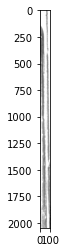

In [7]:
pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni/*.tif'
#pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'
pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'

pezziXimmagine = 1
border = 30

results = []
img_results = []
list_paths = []

list_paths = glob.glob(pathBuoni) 
count = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    try:
        img_results +=  divideImage(cutWorkSpace(img,border),pezziXimmagine)
        count += 1
    except:
        print('errore lettura')

results += [0] * count * pezziXimmagine



list_paths = glob.glob(pathFS)
count = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    try:
        img_results += divideImage(cutWorkSpace(img,border),pezziXimmagine)
        count += 1
    except:
        print('errore lettura')
        
results += [0] * count * pezziXimmagine

#list_paths += glob.glob(pathScarti)
#results += [1] * len(glob.glob(pathScarti)) * pezziXimmagine

#print(results)

#####
# ORA HO IMG_RESULTS & RESULTS
plt.imshow(img_results[1])
plt.show()

In [8]:
if SIFT_method:
    num_features = 128
else:
    num_features = 32

In [9]:
df,cols = dataCreation(img_results,results,num_features)

32


In [10]:
file_name = 'dataframeORB.csv'
#df.to_pickle(file_name) 

In [18]:
df = pd.read_pickle(file_name)


In [88]:
components = 8

In [89]:
cols = []
for i in range(num_features):
    cols.append('F'+str(i+1))

cols.append('R')

In [90]:

finalDf, pca = PCA_SIFT(df,cols,num_features,components)

In [91]:
#finalDf

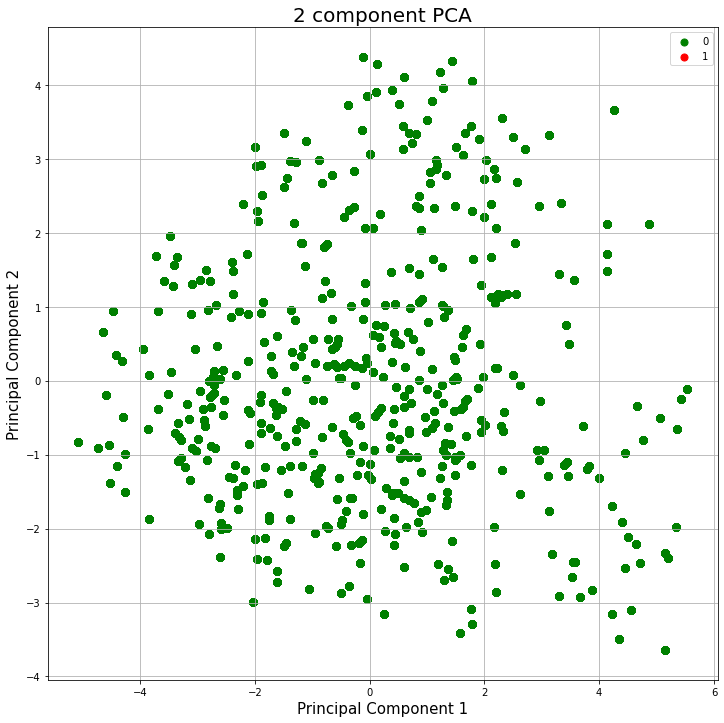

In [92]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['R'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
                #, finalDf.loc[indicesToKeep, 'R']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [124]:
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 5.tif'


list_paths = glob.glob(pathScartiVal)
count = 0
img_results = []
for img_path in list_paths:
    img = cv2.imread(img_path)
    try:
        img_results += divideImage(cutWorkSpace(img,border),pezziXimmagine)
        count += 1
    except:
        print('errore lettura')
        
results = [1] * count * pezziXimmagine

In [125]:
df2,cols = dataCreation(img_results,results,num_features)

32


In [126]:
features = cols[:num_features]
# Separating out the features
x = df2.loc[:, features].values
# Separating out the target
y = df2.loc[:,['R']].values
# Standardizing the features
x = scaler.fit_transform(x)

#pca = PCA(n_components=components)
principalComponents = pca.transform(x)

cols2 = []
for i in range(components):
    cols2.append('PC'+str(i+1))

principalDf = pd.DataFrame(data = principalComponents, columns = cols2)

#concateno valore vero
finalDf2 = pd.concat([principalDf, df2[['R']]], axis = 1)

In [127]:
frames = [finalDf, finalDf2]

finalDf3 = pd.concat(frames)

In [128]:
finalDf3

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,R
0,1.771331,-1.137171,-1.675878,-0.498355,-2.777698,0.448446,-1.447696,-0.182100,0
1,-0.255837,0.195476,3.247259,1.268048,0.257771,0.681627,1.067989,1.184568,0
2,0.589135,3.135991,1.561038,-0.700292,-1.145694,2.136896,-1.963031,-0.680309,0
3,3.457205,-1.291418,2.195838,0.222242,1.532335,0.178011,0.579397,-0.355355,0
4,-0.540668,0.033933,-2.785252,-1.342239,-0.997950,-0.008703,0.478929,1.800847,0
...,...,...,...,...,...,...,...,...,...
495,-0.951834,-1.069247,2.330222,2.265518,-0.353572,-2.487894,-1.782808,1.343354,1
496,-0.607679,0.370259,0.514243,-0.410838,-0.297200,-2.258973,1.129173,-0.621486,1
497,-2.662597,-2.217470,1.577861,2.262023,0.374623,-1.434014,-1.884827,-0.927968,1
498,-1.109375,1.845472,0.369324,0.661023,0.488053,0.743512,2.195221,0.485851,1


Dato un DF restituisco la distanza media e massima dei punti che lo compongono

In [129]:
def maxAndMedian(df):
    df = df.sort_values(by=['PC1'],ascending=False)
    
    features = cols2[:components]
    # Separating out the features
    x = df.loc[:, features].values
    
    maxT = 0
    totale = 0
    if SIFT_method:
        tot_element = [0]*components
    else:
        tot_element = [0]*components
    for element in x:
        temp = np.linalg.norm(element)
        totale += temp
        tot_element += element
        if temp > maxT:
            maxT = temp
            
    media = totale / len(x)
    
    media_list = np.mean(x, axis=0)

    centerDist = np.linalg.norm(tot_element/len(x))
        
    return maxT, media,centerDist

In [130]:
maxT, media,centerDist = maxAndMedian(finalDf2)
print(maxT)
print(media)
print(centerDist)

6.324741487045763
4.064446028170509
8.612538708832856e-16


In [123]:
maxT, media,centerDist = maxAndMedian(finalDf)
print(maxT)
print(media)
print(centerDist)

6.7896790071649775
4.261841899903259
1.8835660000209042e-13


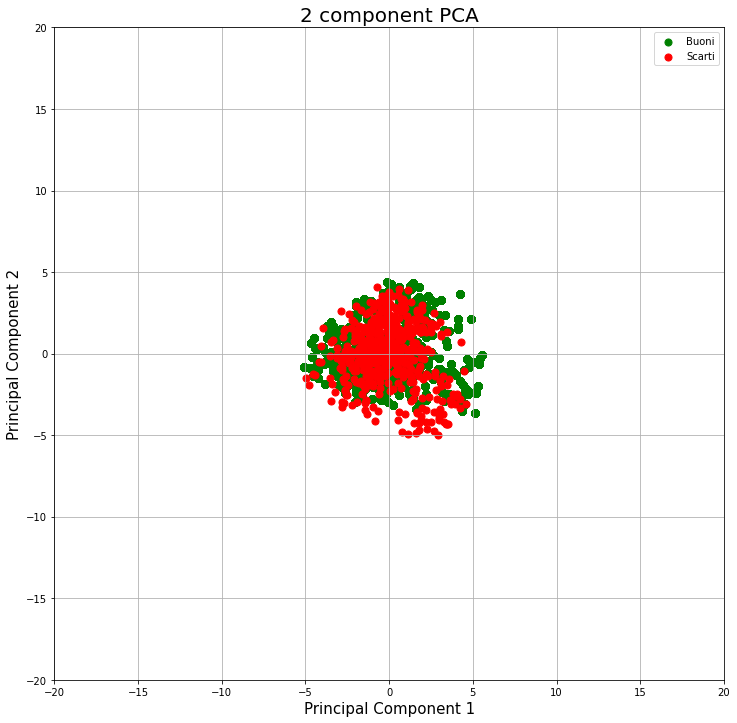

In [132]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ['g', 'r']
#circle = plt.Circle((0, 0), 5.95, color='b')
#ax.add_artist(circle)
for target, color in zip(targets,colors):
    indicesToKeep = finalDf3['R'] == target
    ax.scatter(finalDf3.loc[indicesToKeep, 'PC1']
               , finalDf3.loc[indicesToKeep, 'PC2']
                #, finalDf3.loc[indicesToKeep, 'R']
               , c = color
               , s = 50)
targets = ['Buoni', 'Scarti']
ax.legend(targets)
ax.grid()